In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import cv2
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
from multiprocessing import Process, Queue
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(29)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Initial Data Links
base_dir = '/kaggle/input/dataset/dataset'

In [2]:
### Initial Setup and Label Definitions

import numpy as np
import os
import json
from PIL import Image
from tqdm import tqdm
import gc # For garbage collection

# Hugging Face datasets library for efficient data handling
from datasets import Dataset, DatasetDict

import torch
torch.manual_seed(29) # For reproducibility

print("--- Initial Setup and Label Definitions ---")

# --- 1. Label Definitions ---
# As provided in your code
class Label:
    def __init__(self, name, id, csId, csTrainId, level4id, level3Id, category, level2Id, level1Id, hasInstances, ignoreInEval, color):
        self.name = name
        self.id = id
        self.csId = csId
        self.csTrainId = csTrainId
        self.level4id = level4id
        self.level3Id = level3Id
        self.category = category
        self.level2Id = level2Id
        self.level1Id = level1Id
        self.hasInstances = hasInstances
        self.ignoreInEval = ignoreInEval
        self.color = color

labels_details = [
    Label('road', 0, 7, 0, 0, 0, 'drivable', 0, 0, False, False, (128, 64,128)),
    Label('parking', 1, 9, 255, 1, 1, 'drivable', 1, 0, False, False, (250,170,160)),
    Label('drivable fallback', 2, 255, 255, 2, 1, 'drivable', 1, 0, False, False, ( 81, 0, 81)),
    Label('sidewalk', 3, 8, 1, 3, 2, 'non-drivable', 2, 1, False, False, (244, 35,232)),
    Label('rail track', 4, 10, 255, 3, 3, 'non-drivable', 3, 1, False, False, (230,150,140)),
    Label('non-drivable fallback', 5, 255, 9, 4, 3, 'non-drivable', 3, 1, False, False, (152,251,152)),
    Label('person', 6, 24, 11, 5, 4, 'living-thing', 4, 2, True, False, (220, 20, 60)),
    Label('animal', 7, 255, 255, 6, 4, 'living-thing', 4, 2, True, True, (246, 198, 145)),
    Label('rider', 8, 25, 12, 7, 5, 'living-thing', 5, 2, True, False, (255, 0, 0)),
    Label('motorcycle', 9, 32, 17, 8, 6, '2-wheeler', 6, 3, True, False, ( 0, 0,230)),
    Label('bicycle', 10, 33, 18, 9, 7, '2-wheeler', 6, 3, True, False, (119, 11, 32)),
    Label('autorickshaw', 11, 255, 255, 10, 8, 'autorickshaw', 7, 3, True, False, (255, 204, 54)),
    Label('car', 12, 26, 13, 11, 9, 'car', 7, 3, True, False, ( 0, 0,142)),
    Label('truck', 13, 27, 14, 12, 10, 'large-vehicle', 8, 3, True, False, ( 0, 0, 70)),
    Label('bus', 14, 28, 15, 13, 11, 'large-vehicle', 8, 3, True, False, ( 0, 60,100)),
    Label('caravan', 15, 29, 255, 14, 12, 'large-vehicle', 8, 3, True, True, ( 0, 0, 90)),
    Label('trailer', 16, 30, 255, 15, 12, 'large-vehicle', 8, 3, True, True, ( 0, 0,110)),
    Label('train', 17, 31, 16, 15, 12, 'large-vehicle', 8, 3, True, True, ( 0, 80,100)),
    Label('vehicle fallback', 18, 355, 255, 15, 12, 'large-vehicle', 8, 3, True, False, (136, 143, 153)),
    Label('curb', 19, 255, 255, 16, 13, 'barrier', 9, 4, False, False, (220, 190, 40)),
    Label('wall', 20, 12, 3, 17, 14, 'barrier', 9, 4, False, False, (102,102,156)),
    Label('fence', 21, 13, 4, 18, 15, 'barrier', 10, 4, False, False, (190,153,153)),
    Label('guard rail', 22, 14, 255, 19, 16, 'barrier', 10, 4, False, False, (180,165,180)),
    Label('billboard', 23, 255, 255, 20, 17, 'structures', 11, 4, False, False, (174, 64, 67)),
    Label('traffic sign', 24, 20, 7, 21, 18, 'structures', 11, 4, False, False, (220,220, 0)),
    Label('traffic light', 25, 19, 6, 22, 19, 'structures', 11, 4, False, False, (250,170, 30)),
    Label('pole', 26, 17, 5, 23, 20, 'structures', 12, 4, False, False, (153,153,153)),
    Label('polegroup', 27, 18, 255, 23, 20, 'structures', 12, 4, False, False, (153,153,153)),
    Label('obs-str-bar-fallback', 28, 255, 255, 24, 21, 'structures', 12, 4, False, False, (169, 187, 214)),
    Label('building', 29, 11, 2, 25, 22, 'construction', 13, 5, False, False, ( 70, 70, 70)),
    Label('bridge', 30, 15, 255, 26, 23, 'construction', 13, 5, False, False, (150,100,100)),
    Label('tunnel', 31, 16, 255, 26, 23, 'construction', 13, 5, False, False, (150,120, 90)),
    Label('vegetation', 32, 21, 8, 27, 24, 'vegetation', 14, 5, False, False, (107,142, 35)),
    Label('sky', 33, 23, 10, 28, 25, 'sky', 15, 6, False, False, ( 70,130,180)),
    Label('unlabeled', -1, 0, 255, 255, 255, 'void', 255, 255, False, True, ( 0, 0, 0)),
]

# --- Build Color-to-ID Map and Define Class Constants ---
color_to_id = {tuple(label.color) : label.id for label in labels_details}

# --- Optimized Segmentation Map Conversion Function ---
def convert(seg_map,TARGET_IMAGE_SIZE):
    # Convert the segmentation map image to a numpy array of shape (H, W, 3) where each pixel has RGB values
    seg_map_array = np.array(seg_map.convert('RGB').resize(TARGET_IMAGE_SIZE))

    # Create an empty H * W array to store the pixel-wise label values (id values)
    id_array = np.zeros((seg_map_array.shape[0], seg_map_array.shape[1]), dtype=np.int32)

    # # Iterate over each pixel in the segmentation map
    for i in range(seg_map_array.shape[0]):
        for j in range(seg_map_array.shape[1]):
            pixel_color = tuple(seg_map_array[i, j])
            # Lookup the corresponding id for the pixel's color
            id_array[i, j] = color_to_id.get(pixel_color, -1)  # Default to -1 if the color is not found

    return id_array

# --- Helper function to get image identifier from filename ---
def get_identifier(filename):
    """
    Extracts a numeric identifier from image filenames.
    Assumes filenames like 'frame{ID}_polygons.json' or '{ID}_labelColors.png'.
    """
    parts = filename.split('_')
    if 'frame' in parts[0]:
        return parts[0].replace('frame', '')
    else:
        return parts[0]


--- Initial Setup and Label Definitions ---


# Data Extraction

In [ ]:
### Dataset Selection and Optimized Data Collection

print("\n--- Dataset Selection and Optimized Data Collection ---")

# --- Base directory paths ---
base_path_labels_json = os.path.join(base_dir, 'labels')
train_dir = os.path.join(base_dir, 'train')
labels_dir = os.path.join(base_dir, 'labels')

# --- Dataset Selection Logic (your existing logic for 'richness') ---
rare_classes = ['tunnel','trailer', 'train', 'rectification border', 'rail track', 'parking']
subdir_scores = {}

for subdir in os.listdir(base_path_labels_json):
    class_count = {}
    rare_class_count = 0
    image_count = 0
    json_files = [f for f in os.listdir(os.path.join(base_path_labels_json, subdir)) if f.endswith('_polygons.json')]

    for json_file in json_files:
        image_count += 1
        with open(os.path.join(os.path.join(base_path_labels_json, subdir), json_file), 'r') as file:
            data = json.load(file)
            for obj in data["objects"]:
                label = obj["label"]
                if label:
                    if label in class_count:
                        class_count[label] += 1
                    else:
                        class_count[label] = 1
                    if label in rare_classes:
                        rare_class_count += 1
    
    # Calculate diversity score only if there were classes found
    class_diversity_score = len(class_count) if class_count else 0 
    subdir_scores[subdir] = {
        'class_diversity_score': class_diversity_score,
        'rare_class_score': rare_class_count,
        'image_count': image_count
    }

# Handle cases where max_class_diversity or max_rare_class might be zero to avoid division by zero
max_class_diversity = max([v['class_diversity_score'] for v in subdir_scores.values()])
max_rare_class = max([v['rare_class_score'] for v in subdir_scores.values()])
max_image_count = max([v['image_count'] for v in subdir_scores.values()])

α, β, γ = 0.4, 0.45, 0.15

for subdir, scores in subdir_scores.items():
    norm_diversity = scores['class_diversity_score'] / max_class_diversity
    norm_rare = scores['rare_class_score'] / max_rare_class
    norm_image_count = scores['image_count'] / max_image_count

    weighted_score = (
        α * norm_diversity +
        β * norm_rare +
        γ * norm_image_count
    )
    subdir_scores[subdir]['weighted_score'] = weighted_score

ranked_subdirs = sorted(subdir_scores.items(), key=lambda x: x[1]['weighted_score'], reverse=True)
N = 9 # Top N subdirectories to consider for the dataset

top_subdirs = [subdir for subdir, scores in ranked_subdirs[:N]]
if "296" not in top_subdirs: # Ensure "296" is included only if not already there
    top_subdirs.insert(0, "296")

print(f"Selected top {len(top_subdirs)} subdirectories: {top_subdirs}")


In [ ]:
import os
from PIL import Image
import numpy as np

# Pick any one directory (say the first one)
top_subdirs = os.listdir(train_dir)
dirname = top_subdirs[0]

# Form the full path to images and labels subdirectories
train_subdir = os.path.join(train_dir, dirname)
labels_subdir = os.path.join(labels_dir, dirname)

# List images and labels in the subdirectory
train_images_in_subdir = [f for f in os.listdir(train_subdir) if f.endswith('.jpg')]
label_images_in_subdir = [f for f in os.listdir(labels_subdir) if f.endswith('labelColors.png')]

# Pick any one image — let's take the first one
sample_image_path = os.path.join(labels_subdir, label_images_in_subdir[0])

# Open the image using PIL
image_pil = Image.open(sample_image_path)

# Check dimensions (width, height)
print("Image size (W x H):", image_pil.size)

# Convert to numpy array to get shape and channels
image_np = np.array(image_pil)
print("Image shape (H, W, C):", image_np.shape)
print("Number of channels:", image_np.shape[2])


In [ ]:
# --- Optimized Data Collection into a List of NumPy Arrays ---
optimized_data_list = []
TARGET_IMAGE_SIZE = (256, 256) # Consistent target size for raw images and labels

print("\nStarting optimized data collection from selected directories...")
for dirname in tqdm(top_subdirs, desc="Collecting data"):
    train_subdir = os.path.join(train_dir, dirname)
    labels_subdir = os.path.join(labels_dir, dirname)

    if os.path.isdir(train_subdir) and os.path.isdir(labels_subdir):
        train_images_in_subdir = [f for f in os.listdir(train_subdir) if f.endswith('.jpg')]
        label_images_in_subdir = [f for f in os.listdir(labels_subdir) if f.endswith('labelColors.png')]
        
        for label_image_filename in label_images_in_subdir:
            identifier = get_identifier(label_image_filename)
            matched_train_image_filename = next((img for img in train_images_in_subdir if identifier in img), None)
            
            if matched_train_image_filename:
                pixel_image_path = os.path.join(train_subdir, matched_train_image_filename)
                label_image_path = os.path.join(labels_subdir, label_image_filename)
                
                try:
                    # Open image, resize, and convert to NumPy array (uint8) immediately
                    pixel_image_pil = Image.open(pixel_image_path).resize(TARGET_IMAGE_SIZE)

                    # Open label, convert using optimized function (returns uint8 NumPy array)
                    label_image_pil = Image.open(label_image_path)
                    label_image_np = convert(label_image_pil,TARGET_IMAGE_SIZE)

                    optimized_data_list.append({
                        'pixel_values': pixel_image_pil,
                        'label': label_image_np
                    })
                except Exception as e:
                    print(f"Skipping {identifier} in directory {dirname} due to error: {e}")
                    continue

print(f"Total optimized samples collected: {len(optimized_data_list)}")
gc.collect() # Clean up memory after data collection
data_set = optimized_data_list

In [ ]:
# # IGNORE THIS AS IT WAS USED WHILE TRAINING ON KAGGLE

# import pickle
# # Save the data_set using pickle
# save_path = '/kaggle/working/data_s.pkl'

# with open(save_path, 'wb') as file:
#     pickle.dump(data_set, file)

# print(f'data_set saved to {save_path}')

### (This dataset can be available on request)

In [3]:
# # IGNORE THIS AS IT WAS USED WHILE TRAINING ON KAGGLE

# import pickle

# # Path to your .pkl file
# pkl_file_path = '/kaggle/input/optimized-segmentation-dataset/data_s.pkl'

# # Open and load the .pkl file
# with open(pkl_file_path, 'rb') as f:
#     data_set = pickle.load(f)



# DATA PREPROCESSING

In [4]:
# Listing all unique labels in the dataset
import numpy as np

all_labels = set()

for sample in data_set:
    labels_np = np.array(sample['label'])  # Ensure it's a numpy array
    unique_labels = np.unique(labels_np)
    all_labels.update(unique_labels.tolist())

print("List of all unique labels present in the dataset:", sorted(all_labels))


List of all unique labels present in the dataset: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33]


In [5]:
# Creating Hugging Face Datasets
from datasets import Dataset
dataset = Dataset.from_dict({"pixel_values": [item["pixel_values"] for item in data_set],
                             "label": [item["label"] for item in data_set]})
dataset = dataset.shuffle(seed=1)
dataset = dataset.train_test_split(test_size=0.1)
train_ds, test_ds = dataset["train"], dataset["test"]

dataset = train_ds.train_test_split(test_size=0.05)
train_ds, val_ds = dataset["train"], dataset["test"]

In [6]:
# Creating a map to hash ids to labels
example = train_ds[0]
segmentation_map = np.array(example["label"])
image_array = np.array(example["pixel_values"])
def id_to_label_map():
    new_dict = {}
    for label in labels_details:
        new_dict[int(label.id)] = label.name
    return new_dict
id2label = id_to_label_map()

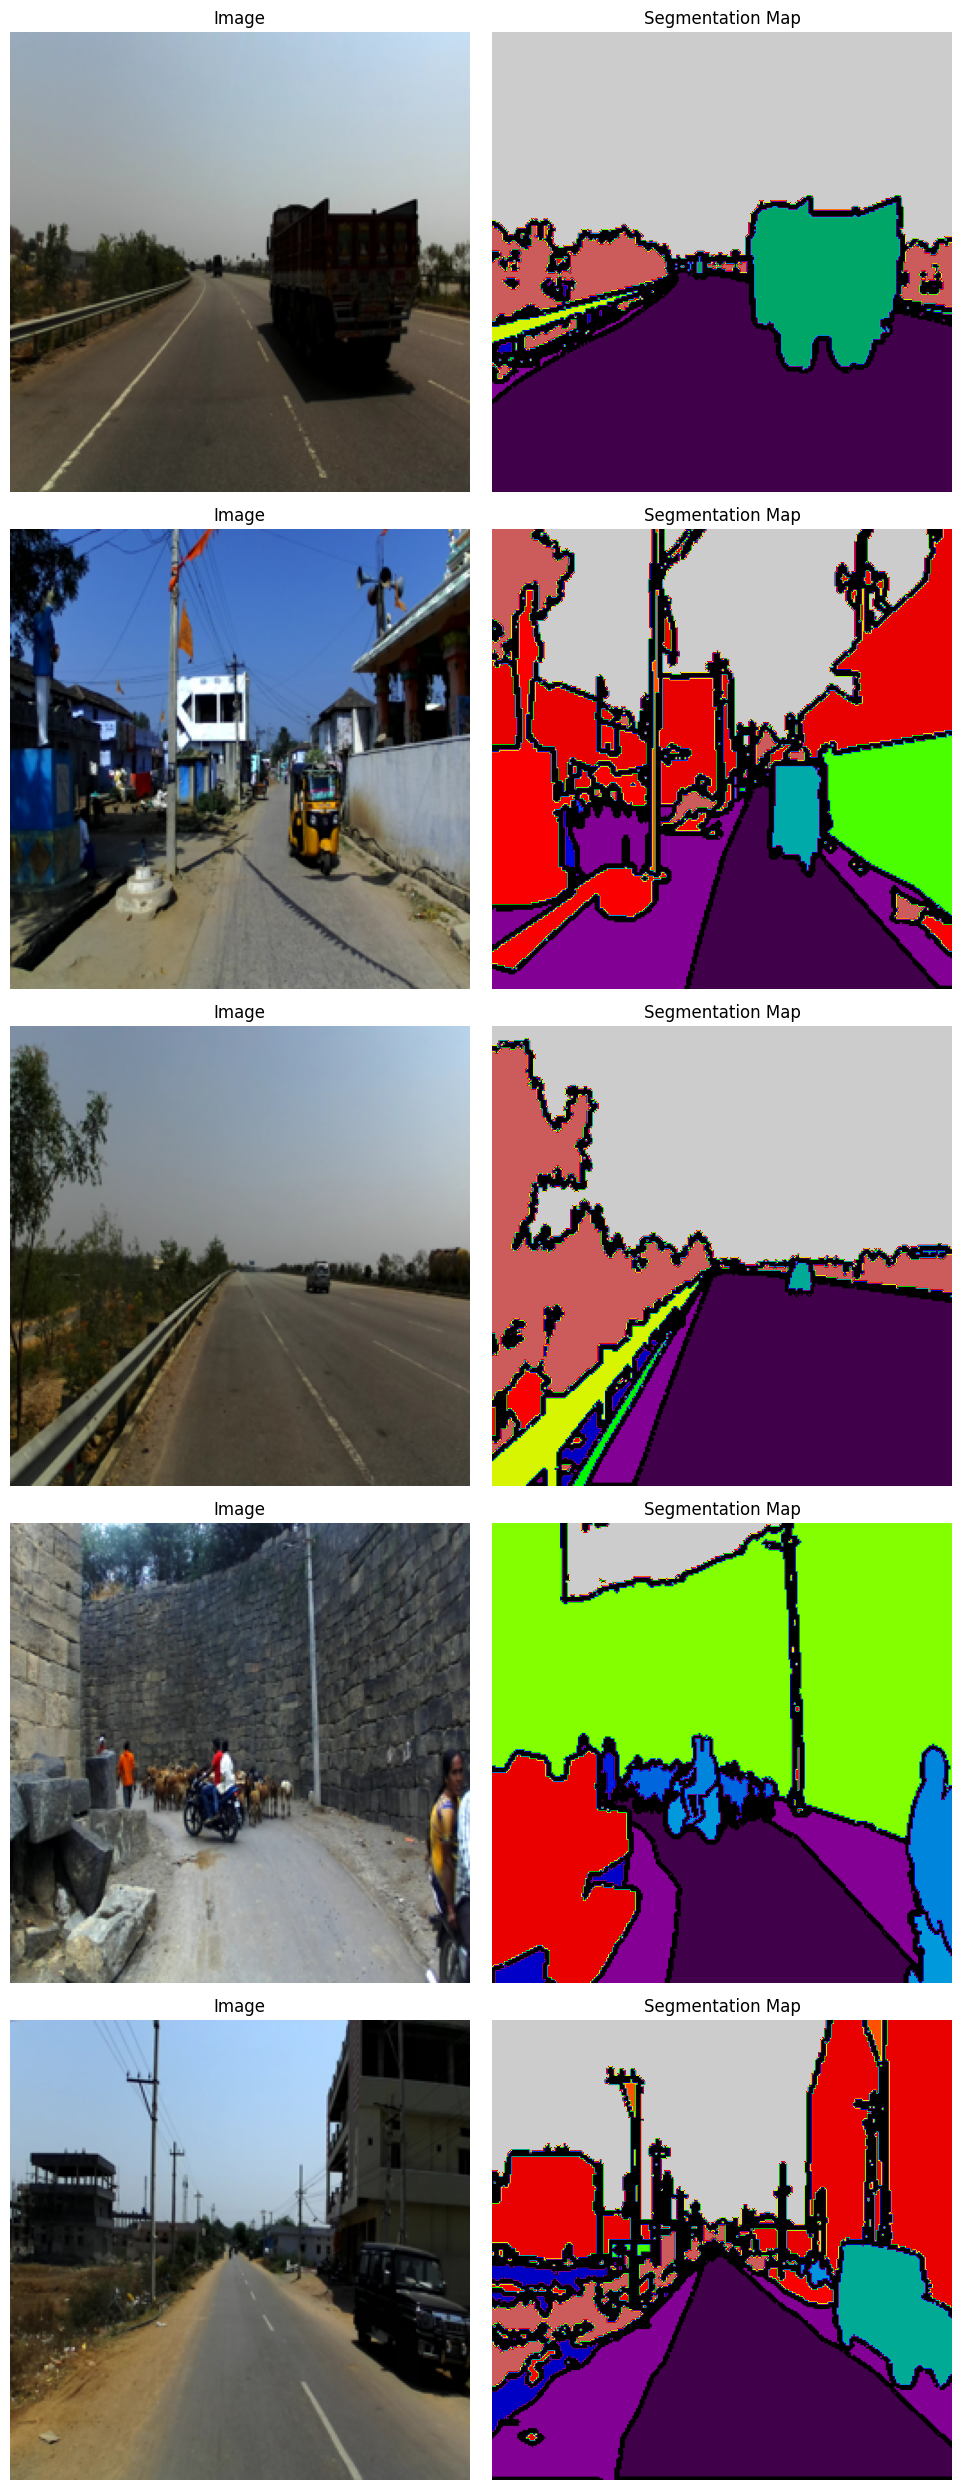

In [7]:
# Sample Images and their segmentation maps without Overlaying
import datasets
def show_samples(dataset: datasets.Dataset, n: int = 5):
    fig, axs = plt.subplots(n, 2, figsize=(10, 5 * n))
    for i in range(n):
        sample = dataset[i]
        image, label = np.array(sample["pixel_values"]), sample["label"]
        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Image")
        axs[i, 0].axis("off")
        axs[i, 1].imshow(image)
        axs[i, 1].imshow(label, cmap="nipy_spectral", alpha=1.0)
        axs[i, 1].set_title("Segmentation Map")
        axs[i, 1].axis("off")
    plt.tight_layout()
    plt.show()
show_samples(train_ds)

In [8]:
# Preprocessing and getting ready our Pytorch Dataloaders for training the model
from torchvision import transforms
import torch
import numpy as np
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import tensorflow as tf
class SegmentationTransform:
    def __init__(self, is_train=True):
        self.is_train = is_train
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image, mask):
        image = self.to_tensor(image)
        mask = torch.from_numpy(np.array(mask)).long()
        if self.is_train and random.random() < 0.5:
            image = torch.flip(image, dims=[2])
            mask = torch.flip(mask, dims=[1])

        return image, mask

class SemanticSegmentationDataset(Dataset):
    def __init__(self, dataset, is_train=True):
        self.dataset = dataset
        self.transform = SegmentationTransform(is_train)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["pixel_values"]
        mask = sample["label"]
        image, mask = self.transform(image, mask)
        return image, mask

train_dataset = SemanticSegmentationDataset(train_ds, is_train=True)
val_dataset = SemanticSegmentationDataset(val_ds, is_train=False)
test_dataset = SemanticSegmentationDataset(test_ds, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)


2025-06-11 07:59:26.510161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749628766.673969      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749628766.723641      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# Function to convert batch-torch data to tensorflow
def convert_batch_to_tensorflow(batch):
    images, masks = batch

    images = images.permute(0, 2, 3, 1).numpy()
    masks = masks.numpy()
    # Replace -1 with 34
    masks = np.where(masks == -1, 34, masks)

    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.int32)
    return images, masks


I0000 00:00:1749628778.771998      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749628778.772772      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


(8, 256, 256, 3)
(8, 256, 256)


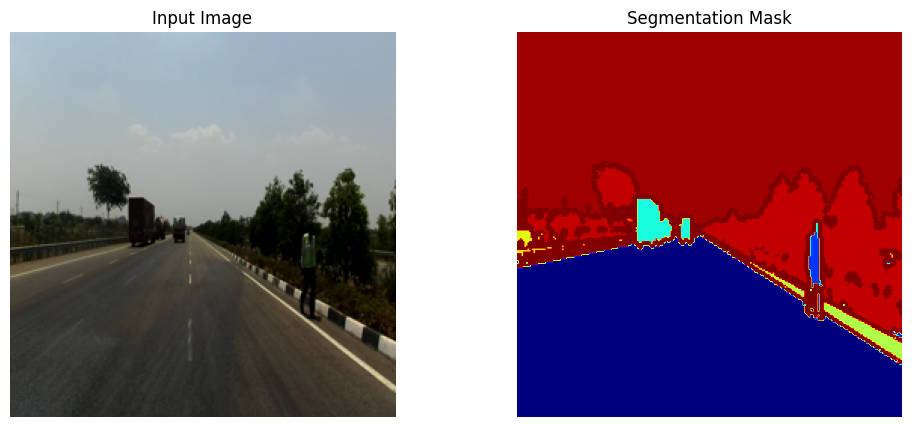

In [10]:
# Checking if the convert_batch_to_tensorflow(batch) works!
import matplotlib.pyplot as plt
import numpy as np

# Get a batch
batch = next(iter(train_loader))
images, masks = convert_batch_to_tensorflow(batch)

# Convert tensors to numpy arrays
images_np = images.numpy()  # shape: (B, H, W, C)
masks_np = masks.numpy()    # shape: (B, H, W)

print(images_np.shape)
print(masks_np.shape)
# Pick an index to visualize (say the first image in batch)
i = 0
# Plot the image
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(images_np[i])
plt.title("Input Image")
plt.axis('off')

# Plot the mask (use a colormap like 'jet' for better visual separation)
plt.subplot(1, 2, 2)
plt.imshow(masks_np[i], cmap='jet')
plt.title("Segmentation Mask")
plt.axis('off')

plt.show()


In [11]:
# Checking number of Unique Mask values Here

unique_vals = np.unique(masks.numpy())
print(f"Unique mask values this batch: {unique_vals}")
print("Unique mask values:", tf.unique(tf.reshape(masks, [-1]))[0].numpy())
images, masks = convert_batch_to_tensorflow(next(iter(train_loader)))
print("Unique mask values in batch:", np.unique(masks))

# MODEL TRAINING
(Note that our model was trained in parts due to longer time in training)

In [12]:
# Setting number of Segmentation Classes present in our current dataset
NUM_SEGMENTATION_CLASSES = 35
print("Number of classes:", NUM_SEGMENTATION_CLASSES)

Number of classes: 35


In [14]:
# Setting input image size
# checkpoint_path is set for training the model in parts
import os
import torch
INPUT_SIZE = 256 
checkpoint_path = f'/kaggle/input/deeplabv3_epoch_70.h5/tensorflow2/default/1/deeplabv3_epoch_70.h5'

In [ ]:
### DeepLabV3+ Model
import tensorflow as tf
print("\n--- DeepLabV3+ Model Definition ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def DeeplabV3Plus(input_shape=(INPUT_SIZE, INPUT_SIZE, 3), num_classes=NUM_SEGMENTATION_CLASSES):
    tf.keras.backend.clear_session() # Clear TF session for clean model creation
    inputs = tf.keras.Input(shape=input_shape)
    
    base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs)

    
    # Let's assume these typical DenseNet layer names for now:
    high_res_features = base_model.get_layer('conv2_block3_out').output
    low_res_features = base_model.get_layer('conv5_block3_out').output

    print(f"High-resolution features shape: {high_res_features.shape}")
    print(f"Low-resolution features shape: {low_res_features.shape}")

    # --- ASPP (Atrous Spatial Pyramid Pooling) Module ---
    # 1x1 convolution branch
    aspp = tf.keras.layers.Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp_conv1x1')(low_res_features)
    aspp = tf.keras.layers.GroupNormalization(groups=32, name='aspp_bn1')(aspp)
    aspp = tf.keras.layers.ReLU(name='aspp_relu1')(aspp)
    
    aspp_rates = [6, 12, 18,24] # Dilation rates for parallel atrous convolutions
    aspp_outputs = [aspp] # Collect all ASPP branch outputs
    
    # Parallel atrous convolution branches
    for i, rate in enumerate(aspp_rates):
        aspp_out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', dilation_rate=rate, use_bias=False, name=f'aspp_conv3x3_d{rate}')(low_res_features)
        aspp_out = tf.keras.layers.GroupNormalization(groups=32, name=f'aspp_bn3_d{rate}')(aspp_out)
        aspp_out = tf.keras.layers.ReLU(name=f'aspp_relu3_d{rate}')(aspp_out)
        aspp_outputs.append(aspp_out)
    
    # Global Average Pooling branch
    global_pool = tf.keras.layers.GlobalAveragePooling2D(name='aspp_global_pool')(low_res_features)
    global_pool = tf.keras.layers.Reshape((1, 1, -1), name='aspp_global_reshape')(global_pool) # Reshape to (1,1,C)
    global_pool = tf.keras.layers.Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp_conv_global')(global_pool)
    global_pool = tf.keras.layers.GroupNormalization(groups=32, name='aspp_bn_global')(global_pool)
    global_pool = tf.keras.layers.ReLU(name='aspp_relu_global')(global_pool)
    
    # Upsample global pooled features to match low_res_features spatial dimensions
    target_height_low_res = tf.keras.backend.int_shape(low_res_features)[1]
    target_width_low_res = tf.keras.backend.int_shape(low_res_features)[2]
    
    global_pool = tf.keras.layers.Resizing(
        height=target_height_low_res, 
        width=target_width_low_res, 
        interpolation='bilinear',
        name='aspp_upsample_global'
    )(global_pool)
    aspp_outputs.append(global_pool)
    
    # Concatenate all ASPP branch outputs
    x = tf.keras.layers.Concatenate(name='aspp_concat')(aspp_outputs)
    
    # 1x1 convolution after ASPP
    x = tf.keras.layers.Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp_final_conv1x1')(x)
    x = tf.keras.layers.GroupNormalization(groups=32, name='aspp_final_bn')(x)
    x = tf.keras.layers.ReLU(name='aspp_final_relu')(x)
    x = tf.keras.layers.Dropout(0.5, name='aspp_dropout')(x) # Dropout for regularization
    
    # --- Decoder Module ---
    # Upsample ASPP output to match high_res_features spatial dimensions
    target_height_high_res = tf.keras.backend.int_shape(high_res_features)[1]
    target_width_high_res = tf.keras.backend.int_shape(high_res_features)[2]
    
    x = tf.keras.layers.Resizing(
        height=target_height_high_res, 
        width=target_width_high_res, 
        interpolation='bilinear',
        name='decoder_upsample_aspp'
    )(x)

    # 1x1 convolution on high-resolution features
    high_res_features = tf.keras.layers.Conv2D(48, (1, 1), padding='same', use_bias=False, name='decoder_highres_conv1x1')(high_res_features)
    high_res_features = tf.keras.layers.GroupNormalization(groups=32, name='decoder_highres_bn')(high_res_features)
    high_res_features = tf.keras.layers.ReLU(name='decoder_highres_relu')(high_res_features)
    
    # Concatenate upsampled ASPP output with refined high-resolution features
    x = tf.keras.layers.Concatenate(name='decoder_concat')([x, high_res_features])
    
    # Final convolutions for segmentation
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', use_bias=False, name='decoder_conv3x3_1')(x)
    x = tf.keras.layers.GroupNormalization(groups=32, name='decoder_bn3x3_1')(x)
    x = tf.keras.layers.ReLU(name='decoder_relu3x3_1')(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', use_bias=False, name='decoder_conv3x3_2')(x)
    x = tf.keras.layers.GroupNormalization(groups=32, name='decoder_bn3x3_2')(x)
    x = tf.keras.layers.ReLU(name='decoder_relu3x3_2')(x)
    
    # Final 1x1 convolution to output class logits
    x = tf.keras.layers.Conv2D(num_classes, (1, 1), padding='same', name='output_logits')(x)
    
    # Upsample to the final INPUT_SIZE (256x256) for pixel-wise classification
    # This is critical as the loss function expects predictions at the input image resolution.
    x = tf.keras.layers.Resizing(INPUT_SIZE, INPUT_SIZE, interpolation='bilinear', name='final_upsample')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x, name='DeeplabV3Plus_ResNet101')
    
    return model


# Create the model instance
if os.path.exists(checkpoint_path):
    print(f"Found checkpoint at {checkpoint_path}, loading model...")
    model = tf.keras.models.load_model(checkpoint_path,compile=False)
else:
    print("No checkpoint found, creating new model...")
    model = DeeplabV3Plus(input_shape=(INPUT_SIZE, INPUT_SIZE, 3), num_classes=NUM_SEGMENTATION_CLASSES)

In [16]:
# Custom Dice Loss for multi-class
def dice_loss(y_true, y_pred, num_classes=NUM_SEGMENTATION_CLASSES, smooth=1e-6):
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)  # shape (batch, H, W, num_classes)
    y_pred_softmax = tf.nn.softmax(y_pred, axis=-1)  # logits -> probabilities
    intersection = tf.reduce_sum(y_true_one_hot * y_pred_softmax, axis=[1, 2])
    union = tf.reduce_sum(y_true_one_hot + y_pred_softmax, axis=[1, 2])
    dice_score = (2. * intersection + smooth) / (union + smooth)
    dice_loss_value = 1 - tf.reduce_mean(dice_score)
    return dice_loss_value

# Combined Loss: weighted sum of CrossEntropy and Dice
def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    ce_loss = tf.reduce_mean(ce_loss)
    d_loss = dice_loss(y_true, y_pred)
    total_loss = 0.7 * ce_loss + 0.3 * d_loss
    return total_loss

print("\n--- Model Compilation and Training with Combined Loss ---")

# MODEL COMPILATION
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=combined_loss,
    metrics=['accuracy']
)

# MODEL TRAINING
def train_model(model, train_dataloader, val_dataloader, epochs=5):
    train_loss_history = []
    val_loss_history = []
    
    print(f"Starting training for {epochs} epochs...")
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # --- Training Loop ---
        train_loss = 0
        train_accuracy = 0
        train_steps = 0
        
        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
            images, masks = convert_batch_to_tensorflow(batch)
            metrics = model.train_on_batch(images, masks)
            batch_loss, batch_accuracy = metrics
            
            train_loss += batch_loss
            train_accuracy += batch_accuracy
            train_steps += 1
            
            if train_steps % 200 == 0:
                gc.collect()
        
        avg_train_loss = train_loss / train_steps
        avg_train_accuracy = train_accuracy / train_steps
        train_loss_history.append(avg_train_loss)
        
        # --- Validation Loop ---
        val_loss = 0
        val_accuracy = 0
        val_steps = 0
        
        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}"):
            images, masks = convert_batch_to_tensorflow(batch)
            metrics = model.test_on_batch(images, masks)
            batch_loss, batch_accuracy = metrics
            
            val_loss += batch_loss
            val_accuracy += batch_accuracy
            val_steps += 1
        
        avg_val_loss = val_loss / val_steps
        avg_val_accuracy = val_accuracy / val_steps
        val_loss_history.append(avg_val_loss)
        
        print(f"Epoch {epoch+1} Summary: Train Loss = {avg_train_loss:.4f}, Train Acc = {avg_train_accuracy:.4f}")
        print(f"                       Val Loss = {avg_val_loss:.4f}, Val Acc = {avg_val_accuracy:.4f}")
        
        if((epoch+1)%5==0):
            model.save(f'/kaggle/working/deeplabv3_epoch_{epoch+1}.h5')
            print(f"Checkpoint saved at epoch {epoch+1}")
        gc.collect()
        
    return train_loss_history, val_loss_history
train_loss, val_loss = train_model(model, train_loader, val_loader, epochs=100)
print("\nTraining complete.")



--- Model Compilation and Training with Combined Loss ---
Starting training for 30 epochs...

Epoch 1/30


Training Epoch 1:   0%|          | 0/752 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1749628932.850321      35 service.cc:148] XLA service 0xa32c19d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749628932.851209      35 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749628932.851235      35 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749628941.126277      35 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-11 08:02:29.489316: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[256,1152,1,1]{3,2,1,0}, u8[0]{0}) custom-call(f32[2048,1152,3,3]{3,2,1,0}, f32[2048,256,3,3]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":

Epoch 1 Summary: Train Loss = 0.2898, Train Acc = 0.9287
                       Val Loss = 0.2896, Val Acc = 0.9286

Epoch 2/30


Validation Epoch 2: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


Epoch 2 Summary: Train Loss = 0.2890, Train Acc = 0.9288
                       Val Loss = 0.2889, Val Acc = 0.9289

Epoch 3/30


Validation Epoch 3: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


Epoch 3 Summary: Train Loss = 0.2887, Train Acc = 0.9289
                       Val Loss = 0.2885, Val Acc = 0.9290

Epoch 4/30


Validation Epoch 4: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


Epoch 4 Summary: Train Loss = 0.2882, Train Acc = 0.9292
                       Val Loss = 0.2880, Val Acc = 0.9292

Epoch 5/30


Validation Epoch 5: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


Epoch 5 Summary: Train Loss = 0.2877, Train Acc = 0.9293
                       Val Loss = 0.2876, Val Acc = 0.9294
Checkpoint saved at epoch 75

Epoch 6/30


Validation Epoch 6: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


Epoch 6 Summary: Train Loss = 0.2874, Train Acc = 0.9295
                       Val Loss = 0.2872, Val Acc = 0.9295

Epoch 7/30


Validation Epoch 7: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


Epoch 7 Summary: Train Loss = 0.2870, Train Acc = 0.9296
                       Val Loss = 0.2869, Val Acc = 0.9297

Epoch 8/30


Validation Epoch 8: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


Epoch 8 Summary: Train Loss = 0.2867, Train Acc = 0.9297
                       Val Loss = 0.2866, Val Acc = 0.9298

Epoch 9/30


Validation Epoch 9: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


Epoch 9 Summary: Train Loss = 0.2864, Train Acc = 0.9298
                       Val Loss = 0.2863, Val Acc = 0.9299

Epoch 10/30


Validation Epoch 10: 100%|██████████| 40/40 [00:13<00:00,  2.91it/s]


Epoch 10 Summary: Train Loss = 0.2861, Train Acc = 0.9300
                       Val Loss = 0.2860, Val Acc = 0.9300
Checkpoint saved at epoch 80

Epoch 11/30


Validation Epoch 11: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


Epoch 11 Summary: Train Loss = 0.2859, Train Acc = 0.9301
                       Val Loss = 0.2857, Val Acc = 0.9301

Epoch 12/30


Validation Epoch 12: 100%|██████████| 40/40 [00:13<00:00,  2.91it/s]


Epoch 12 Summary: Train Loss = 0.2857, Train Acc = 0.9301
                       Val Loss = 0.2855, Val Acc = 0.9302

Epoch 13/30


Validation Epoch 13: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


Epoch 13 Summary: Train Loss = 0.2854, Train Acc = 0.9303
                       Val Loss = 0.2853, Val Acc = 0.9303

Epoch 14/30


Validation Epoch 14: 100%|██████████| 40/40 [00:13<00:00,  2.90it/s]


Epoch 14 Summary: Train Loss = 0.2852, Train Acc = 0.9304
                       Val Loss = 0.2851, Val Acc = 0.9304

Epoch 15/30


Validation Epoch 15: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


Epoch 15 Summary: Train Loss = 0.2850, Train Acc = 0.9304
                       Val Loss = 0.2849, Val Acc = 0.9305
Checkpoint saved at epoch 85

Epoch 16/30


Validation Epoch 16: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


Epoch 16 Summary: Train Loss = 0.2848, Train Acc = 0.9305
                       Val Loss = 0.2847, Val Acc = 0.9306

Epoch 17/30


Validation Epoch 17: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


Epoch 17 Summary: Train Loss = 0.2845, Train Acc = 0.9306
                       Val Loss = 0.2845, Val Acc = 0.9306

Epoch 18/30


Validation Epoch 18: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


Epoch 18 Summary: Train Loss = 0.2844, Train Acc = 0.9307
                       Val Loss = 0.2843, Val Acc = 0.9307

Epoch 19/30


Validation Epoch 19: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


Epoch 19 Summary: Train Loss = 0.2842, Train Acc = 0.9308
                       Val Loss = 0.2841, Val Acc = 0.9308

Epoch 20/30


Validation Epoch 20: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


Epoch 20 Summary: Train Loss = 0.2840, Train Acc = 0.9308
                       Val Loss = 0.2839, Val Acc = 0.9308
Checkpoint saved at epoch 90

Epoch 21/30


Validation Epoch 21: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


Epoch 21 Summary: Train Loss = 0.2839, Train Acc = 0.9309
                       Val Loss = 0.2838, Val Acc = 0.9309

Epoch 22/30


Validation Epoch 22: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


Epoch 22 Summary: Train Loss = 0.2837, Train Acc = 0.9310
                       Val Loss = 0.2836, Val Acc = 0.9310

Epoch 23/30


Validation Epoch 23: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


Epoch 23 Summary: Train Loss = 0.2835, Train Acc = 0.9310
                       Val Loss = 0.2835, Val Acc = 0.9310

Epoch 24/30


Validation Epoch 24: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


Epoch 24 Summary: Train Loss = 0.2834, Train Acc = 0.9311
                       Val Loss = 0.2833, Val Acc = 0.9311

Epoch 25/30


Validation Epoch 25: 100%|██████████| 40/40 [00:13<00:00,  2.90it/s]


Epoch 25 Summary: Train Loss = 0.2832, Train Acc = 0.9311
                       Val Loss = 0.2832, Val Acc = 0.9312
Checkpoint saved at epoch 95

Epoch 26/30


Validation Epoch 26: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


Epoch 26 Summary: Train Loss = 0.2831, Train Acc = 0.9312
                       Val Loss = 0.2830, Val Acc = 0.9312

Epoch 27/30


Validation Epoch 27: 100%|██████████| 40/40 [00:13<00:00,  2.91it/s]


Epoch 27 Summary: Train Loss = 0.2830, Train Acc = 0.9313
                       Val Loss = 0.2829, Val Acc = 0.9313

Epoch 28/30


Validation Epoch 28: 100%|██████████| 40/40 [00:13<00:00,  2.90it/s]


Epoch 28 Summary: Train Loss = 0.2828, Train Acc = 0.9313
                       Val Loss = 0.2828, Val Acc = 0.9313

Epoch 29/30


Validation Epoch 29: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


Epoch 29 Summary: Train Loss = 0.2827, Train Acc = 0.9314
                       Val Loss = 0.2826, Val Acc = 0.9314

Epoch 30/30


Validation Epoch 30: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


Epoch 30 Summary: Train Loss = 0.2826, Train Acc = 0.9314
                       Val Loss = 0.2825, Val Acc = 0.9314
Checkpoint saved at epoch 100

Training complete.


In [18]:
# Saving Final Model checkpoint
model.save(f'/kaggle/working/deeplabv3_epoch_{100}.h5')
print(f"Checkpoint saved at epoch {100}")

Checkpoint saved at epoch 100


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


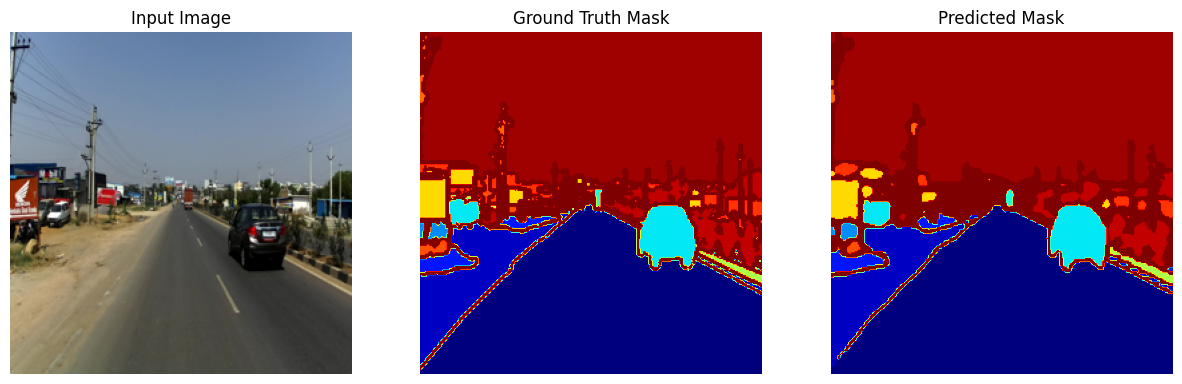

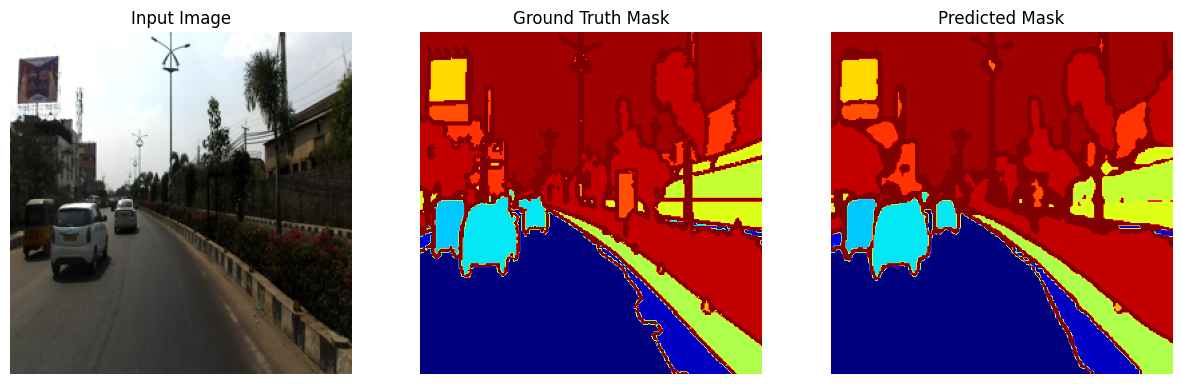

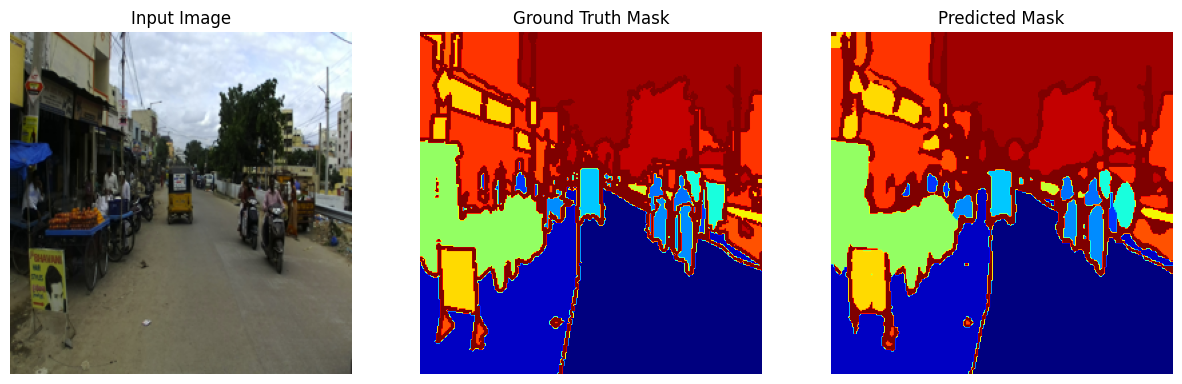

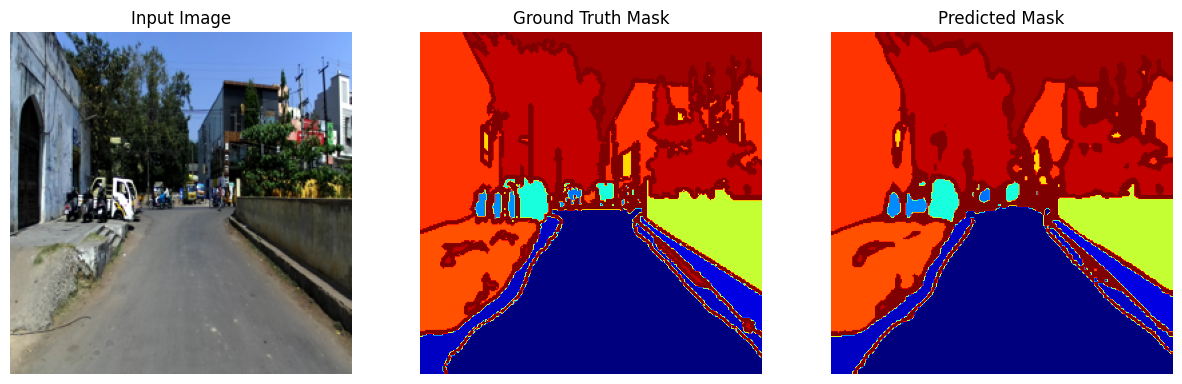

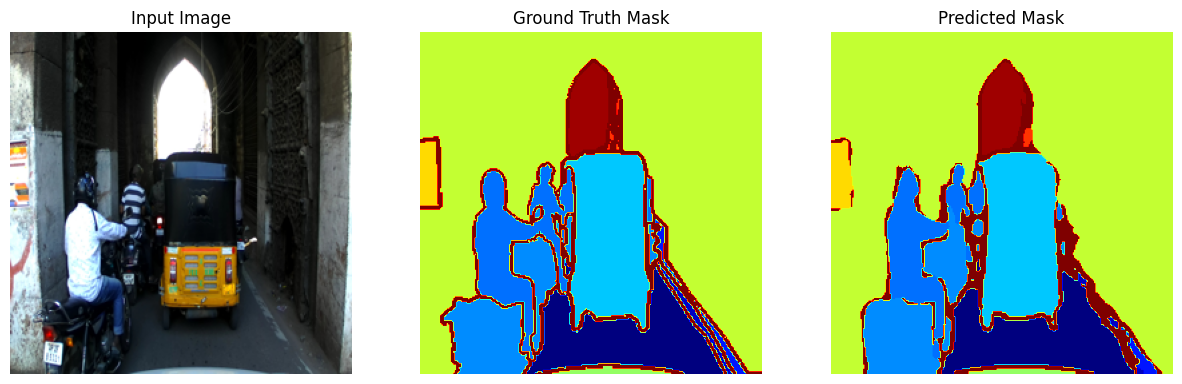

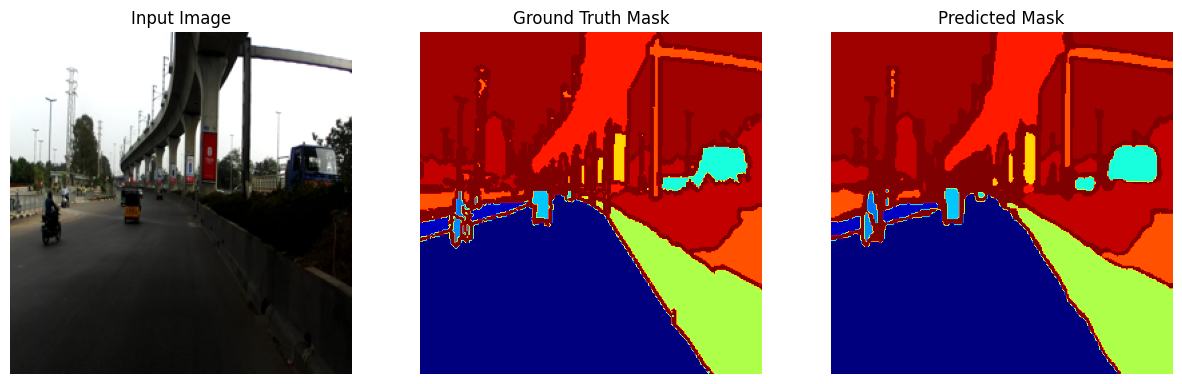

In [17]:
# Testing and Visualizing on Test Images
def visualize_predictions(model, dataloader, num_samples=5):
    batch = next(iter(dataloader))
    images_tf, true_masks_tf = convert_batch_to_tensorflow(batch)

    # Run predictions
    preds = model.predict(images_tf)  # shape: (B, H, W, num_classes)
    preds = tf.argmax(preds, axis=-1).numpy()  # shape: (B, H, W)

    images_np = images_tf.numpy()
    true_masks_np = true_masks_tf.numpy()

    for i in range(num_samples):
        image_np = images_np[i]
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # normalize

        true_mask_np = true_masks_np[i]
        pred_mask_np = preds[i]

        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask_np, cmap='jet')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_np, cmap='jet')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

# Usage
visualize_predictions(model, test_loader, num_samples=6)
